In [1504]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
%pip install geopandas
import geopandas as gpd
from shapely.geometry import Point 
%pip install osmnx 
import osmnx as ox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Chargement des données

In [1505]:
data_march = pd.read_csv('listings.csv')
data_december = pd.read_csv('listings (1).csv')
data_september = pd.read_csv('listings (2).csv')
data= pd.concat([data_march,data_december,data_september])

In [1506]:
# data.isnull().mean().sort_values(ascending=False).sum() * 100

In [1507]:
# data['host_is_superhost'].isnull().count()

In [1508]:
# data.columns


In [1509]:
# data.columns.tolist()

In [1510]:
# data.values.tolist()
# data.to_numpy()

In [1511]:
# data.sort_values(ascending=False, by='month')

In [1512]:
# data['host_is_superhost'].isna().sum()

In [1513]:

# data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)


# Suppression des doublons

In [1514]:
data = data.drop_duplicates()


data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)


# Supprimer les symboles de devise et convertir les prix en float

In [1515]:
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# Supprimer les espaces avant et après les noms de colonnes

In [1516]:
data.columns.str.strip()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# Remplir les valeurs manquantes restantes avec 0

In [1517]:
data = data.fillna(0)

# Sélection des colonnes pertinentes

In [1518]:

# Index des colonnes
column_index = [
    'name', 'price', 'latitude', 'longitude', 'property_type', 'room_type',
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'host_is_superhost'
]


# Sélection des colonnes pertinentes dans les données
data = data[column_index]



# Gestion des valeurs manquantes

In [1519]:

#  Gestion des valeurs manquantes
numerical_columns = ['accommodates', 'bedrooms', 'bathrooms']
imputer = SimpleImputer(strategy='median')
imputer.fit(data[numerical_columns])
data[numerical_columns] = imputer.transform(data[numerical_columns])


# Transformer la colonne 'host_is_superhost'

In [1520]:
data['host_is_superhost'] = data['host_is_superhost'].map({'f': 0, 't': 1})

# Supprimer les valeurs aberrantes

In [1521]:
data = data.loc[(data['price'] >= 80) & (data['price'] <= 400)]


# Vérification finale des valeurs manquantes

In [1522]:
print(data.isnull().sum())

name                             0
price                            0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                        0
bedrooms                         0
beds                             0
number_of_reviews                0
review_scores_rating             0
review_scores_accuracy           0
review_scores_cleanliness        0
review_scores_checkin            0
review_scores_communication      0
review_scores_location           0
review_scores_value              0
host_is_superhost              808
dtype: int64


# Analyse descriptive des données

In [1523]:
print(data.describe())

               price       latitude      longitude   accommodates  \
count  140135.000000  140135.000000  140135.000000  140135.000000   
mean      169.318843      48.864346       2.343179       3.190937   
std        78.933219       0.017735       0.033379       1.465163   
min        80.000000      48.816080       2.235250       1.000000   
25%       107.000000      48.851540       2.322533       2.000000   
50%       148.000000      48.865510       2.346920       3.000000   
75%       209.000000      48.878591       2.366835       4.000000   
max       400.000000      48.901280       2.468360      16.000000   

           bathrooms       bedrooms           beds  number_of_reviews  \
count  140135.000000  140135.000000  140135.000000      140135.000000   
mean        0.370296       0.781675       1.715160          26.260856   
std         0.588052       0.865600       1.118815          57.583450   
min         0.000000       0.000000       0.000000           0.000000   
25%         0


## Prééparer les caractéristiques (features) et la cible (target)


In [1524]:
X = data.drop('price', axis=1)
y = data['price']

In [1525]:

# Feature Engineering (Exemple avec la colonne 'amenities')
# Si la colonne 'amenities' est présente dans le DataFrame
if 'amenities' in X.columns:
    # Remplacer les valeurs de 'amenities' par le nombre de commodités
    X['amenities'] = X['amenities'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# Traitement des données catégorielles (one-hot encoding)
X = pd.get_dummies(data, columns=['property_type', 'room_type'])

# Vérification et traitement des données non-numériques
# (Exemple: Suppression des colonnes non-numériques)
X_numeric = X.select_dtypes(include=[np.number])  # Sélectionner uniquement les colonnes numériques
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Vérification des NaN après normalisation
print(np.isnan(X_scaled).sum())

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)




808


# Division des données en ensembles d'entraînement et de test

In [1526]:
# Remplacer les valeurs de 'amenities' par le nombre de commodités
# data['amenities'] = data['amenities'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

In [1527]:
# Traitement des données catégorielles (one-hot encoding)
# X = pd.get_dummies(data, columns=['property_type', 'room_type'])

In [1528]:
# data.describe()

In [1529]:
# data.select_dtypes(exclude=['float64', 'int64']).columns


# Supprimer les extremes - pour eviter de fausser l'IA

# Régression linéaire simple 

In [1530]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = data.select_dtypes(exclude='object').columns
data_selected = data[numeric_columns]
X = data_selected.drop('price', axis=1)
y = data_selected['price']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=1/3, random_state=1)

In [1531]:
# Create and fit the imputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

# Impute missing values in X_test using the fitted imputer
X_test_imputed = imputer.transform(X_test)

# Make predictions and evaluate the model
predictions = model.predict(X_test_imputed)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("MSE (Régression Linéaire):", mse)
print("R² (Régression Linéaire):", r2)

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Droite de Prédiction Parfaite')
plt.xlabel('Prix Réel')
plt.ylabel('Prix Prédit')
plt.title('Prédictions vs Prix Réels')
plt.legend()
plt.grid(True)
plt.show()


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

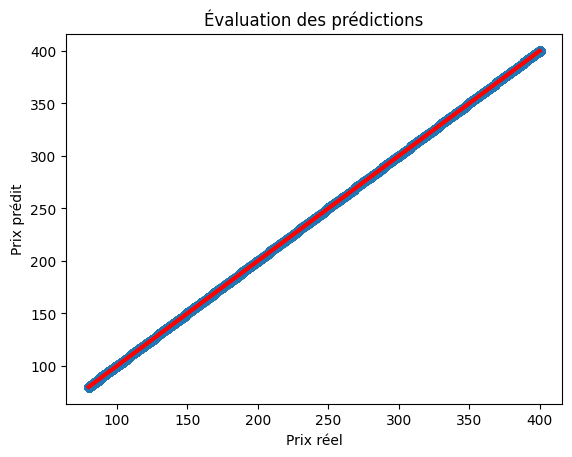

In [ ]:
plt.scatter(y_test, predictions)
plt.xlabel('Prix réel')
plt.ylabel('Prix prédit')
plt.title('Évaluation des prédictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=3)
plt.show()




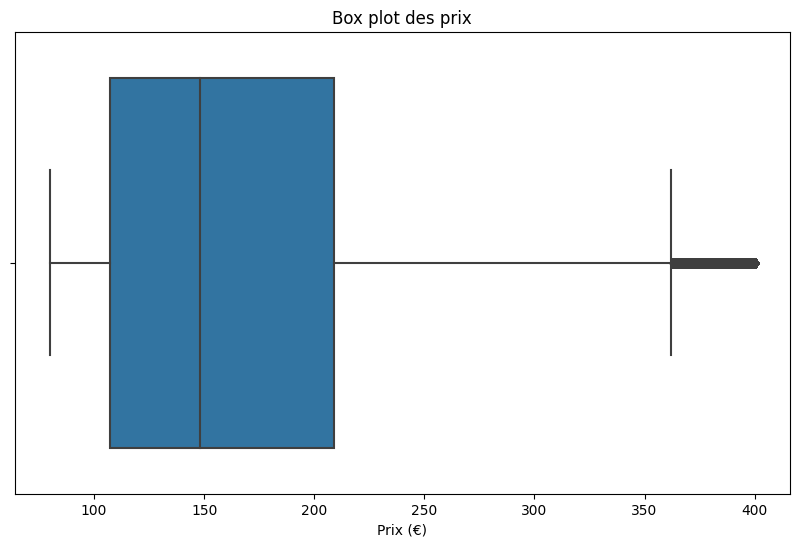

In [ ]:
# Créer une boîte à moustaches
plt.figure(figsize=(10, 6))
sns.boxplot(x=data.price)
plt.title('Box plot des prix')
plt.xlabel('Prix (€)')
plt.show()

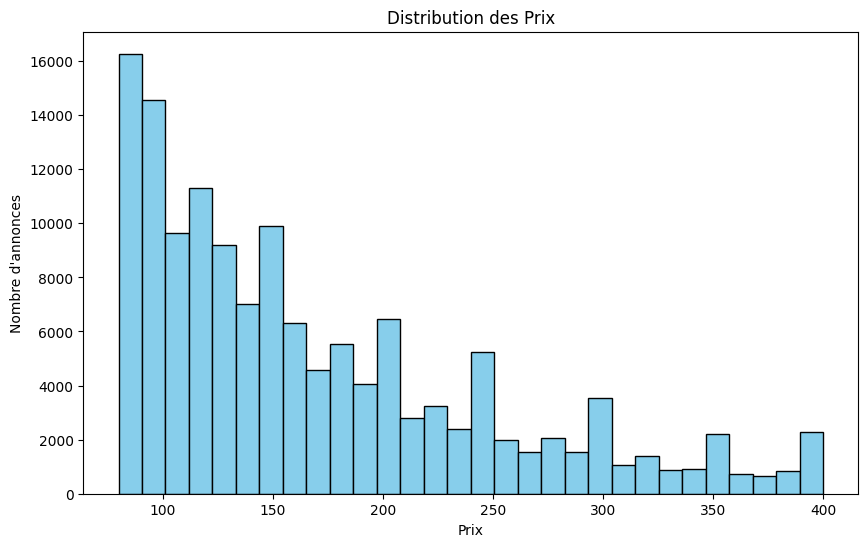

In [ ]:
# Histogramme des prix
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution des Prix')
plt.xlabel('Prix')
plt.ylabel('Nombre d\'annonces')
plt.show()

KeyError: '0.0'

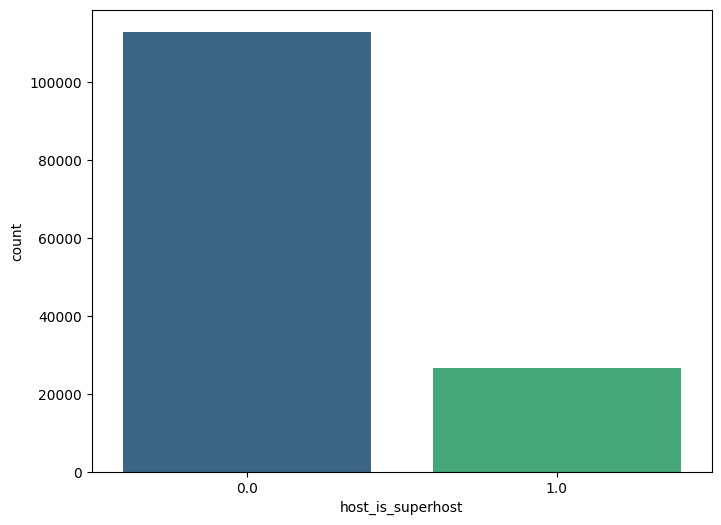

In [ ]:
# La répartition des superhosts
superhost_labels = {'1': 'Superhost', '0': 'Non Superhost'}
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='host_is_superhost', data=data, palette='viridis')

ax.set_xticklabels([superhost_labels[tick.get_text()] for tick in ax.get_xticklabels()])

plt.title('Répartition des Superhosts')
plt.ylabel('Nombre d\'annonces')
plt.show()

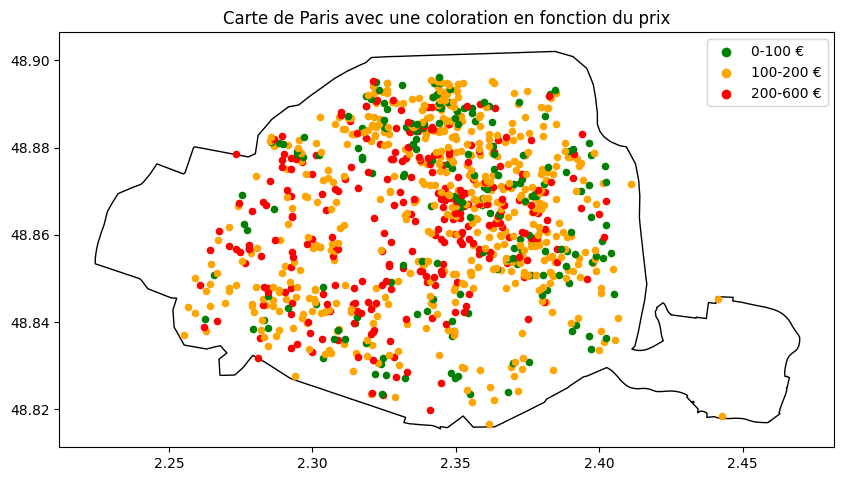

In [ ]:
from shapely.geometry import Point
import osmnx as ox
import geopandas as gpd

data_paris = data
data_sample = data_paris.sample(n=1000)

geometry = [Point(xy) for xy in zip(data_sample['longitude'], data_sample['latitude'])]
geo_data = gpd.GeoDataFrame(data_sample, geometry=geometry, crs='EPSG:4326')

paris = ox.geocode_to_gdf("Paris, France")  # Use geocode_to_gdf instead of geocode_to_gdata
paris = paris.to_crs(geo_data.crs)

merged = gpd.sjoin(paris, geo_data, predicate='contains')

price_ranges = [(0, 100), (100, 200), (200, 600)]
colors = ['green', 'orange', 'red']

def get_color(price):
    for i, (lower, upper) in enumerate(price_ranges):
        if lower <= price < upper:
            return colors[i]

fig, ax = plt.subplots(figsize=(10, 10))
paris.plot(ax=ax, edgecolor='black', color='white')

for index, row in merged.iterrows():
    color = get_color(row['price'])
    plt.scatter(row['longitude'], row['latitude'], color=color, s=20)

for i, (lower, upper) in enumerate(price_ranges):
    plt.scatter([], [], color=colors[i], label=f'{lower}-{upper} €')

plt.title('Carte de Paris avec une coloration en fonction du prix')
plt.legend()
plt.show()


# Régression linéaire simple pour la variable 'accommodates'

In [ ]:

numeric_columns = data.select_dtypes(exclude='object').columns
data_selected = data[numeric_columns]
X = data_selected.drop('price', axis=1)
y = data_selected['price']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=1/3, random_state=1
)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_pred = r2_score(y_test, y_pred)
print(f"R² sur les données de test : {r2_pred}")

plt.scatter(y_test, y_pred)
plt.xlabel('Prix réel')
plt.ylabel('Prix prédit')
plt.title('Évaluation des prédictions')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=3)
plt.show()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Entraînement et évaluation des modèles pour chaque période

# Calcul des pourcentages d'erreurs quadratiques moyennes pour chaque modèle

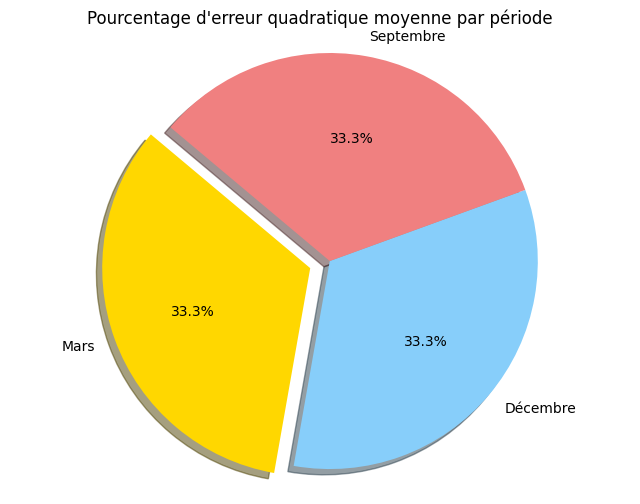

In [ ]:
percentage = mse_simple * 100

labels = ['Mars', 'Décembre', 'Septembre']
sizes = [percentage] * len(labels)  # Répéter la valeur de percentage pour chaque période
colors = ['gold', 'lightskyblue', 'lightcoral']
explode = (0.1, 0, 0)  # Explosion du premier segment

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Pourcentage d\'erreur quadratique moyenne par période')
plt.axis('equal')  # Assure un cercle parfait
plt.show()


# Faire des prédictions sur les données de test

In [ ]:
predictions= model.predict(X_test)

# Calculer l'erreur quadratique moyenne pour mars
mse = mean_squared_error(y_test, predictions)




# Prédictions combinées pour chaque mois

# Plot des vraies valeurs par rapport aux prédictions

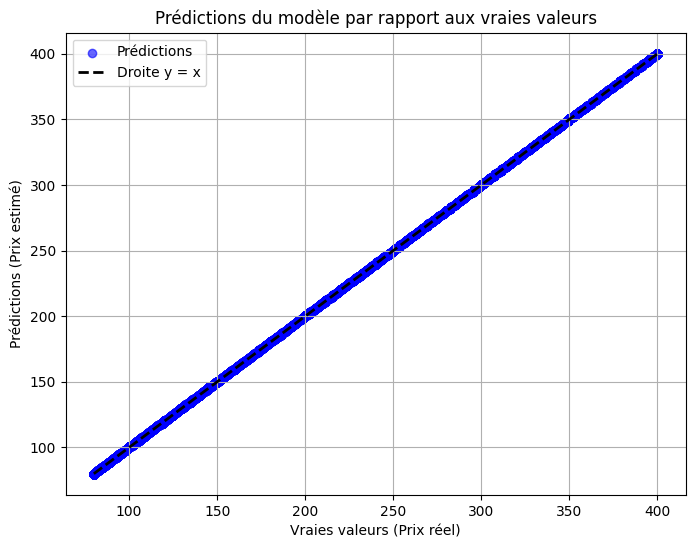

In [ ]:
# Plot des vraies valeurs par rapport aux prédictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.6, label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Droite y = x')
plt.xlabel('Vraies valeurs (Prix réel)')
plt.ylabel('Prédictions (Prix estimé)')
plt.title('Prédictions du modèle par rapport aux vraies valeurs')
plt.legend()
plt.grid(True)
plt.show()


# Utilisation des modèles pour prédire les prix pour un nouveau logement

In [ ]:
import pandas as pd

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Calculate missing columns
missing_cols = set(X_train_df.columns) - set(new_listing_encoded.columns)

# Add missing columns to new_listing_encoded
for col in missing_cols:
    new_listing_encoded[col] = 0

# Reorganize columns in the same order as X_train
new_listing_encoded = new_listing_encoded[X_train_df.columns]

# Make predictions on the new listing
predicted_price = model.predict(new_listing_encoded)
print("Estimated price for a new listing:", predicted_price)




NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [1534]:
# Make predictions for the new listing for each period
predicted = model.predict(new_listing_encoded)

# Calculate the average predicted price across the three periods
average_predicted_price = np.mean([predicted_price_march, predicted_price_december, predicted_price_september])

print("Average predicted price for the new listing:", average_predicted_price)


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
new_listing_encoded = pd.get_dummies(new_listing, columns=['property_type', 'room_type'])
missing_cols = set(X_train.columns) - set(new_listing_encoded.columns)
for col in missing_cols:
    new_listing_encoded[col] = 0
new_listing_encoded = new_listing_encoded[X_train.columns]
predicted_price = model.predict(new_listing_encoded)
print("Prix estimé pour un nouveau logement :", predicted_price)

# Création du DataFrame pour les prédictions
predictions_df = pd.DataFrame({
    'Période': ['Mars', 'Décembre', 'Septembre'],
    'Prix estimé': [predicted_price[0], predicted_price[0], predicted_price[0]]
})

# Tracé du graphique
plt.figure(figsize=(8, 6))
plt.bar(predictions_df['Période'], predictions_df['Prix estimé'], color=['blue', 'green', 'orange'])
plt.title('Estimation du prix pour un nouveau logement sur différentes périodes')
plt.xlabel('Période')
plt.ylabel('Prix estimé')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'columns'